In [1]:
%pip install matplotlib
%pip install pandas
%pip install prophet
%pip install numpy
%pip install scikit-learn
%pip install statsmodels

import gc
import pandas as pd
from pandas.errors import DtypeWarning
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from matplotlib.ticker import FuncFormatter
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

import numpy as np
import statsmodels.api as sm
import warnings

# Suppress RuntimeWarnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=DtypeWarning)

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


Importing plotly failed. Interactive plots will not work.


In [2]:
input_parquet_file_path = '../data/interm/4.0_commune.parquet'

code_insee_identifier = 'Clean code INSEE'

# Forecast the total revenue generated at the municipality level

In [3]:
# Define a function to format the y-axis labels to display in millions
def human_readable_format(x, pos=None):
    """
    Converts a number into a human-readable format (K, M, B, T).
    
    Parameters:
    x (float): The number to be converted.
    pos (optional): The position (not used, but required for compatibility with matplotlib).

    Returns:
    str: The human-readable format of the number.
    """
    if x >= 1e12:
        return f'{x / 1e12:.1f}T'
    elif x >= 1e9:
        return f'{x / 1e9:.1f}B'
    elif x >= 1e6:
        return f'{x / 1e6:.1f}M'
    elif x >= 1e3:
        return f'{x / 1e3:.1f}K'
    else:
        return str(x)

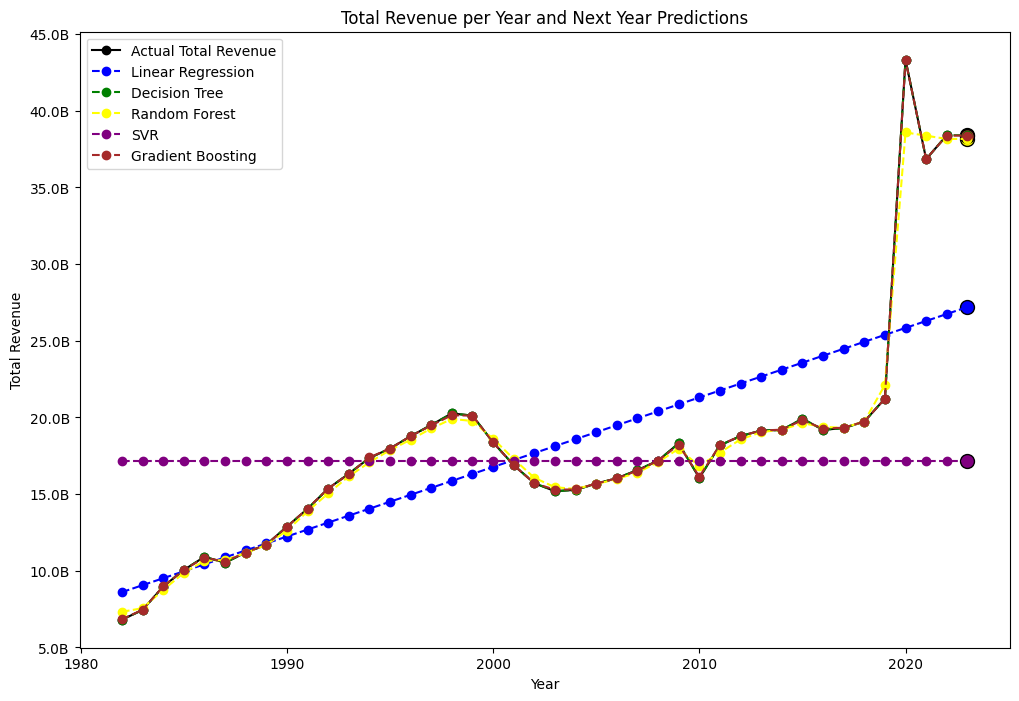

Next Year Predicted Revenue by Linear Regression: 27.2B
Next Year Predicted Revenue by Decision Tree: 38.4B
Next Year Predicted Revenue by Random Forest: 38.2B
Next Year Predicted Revenue by SVR: 17.2B
Next Year Predicted Revenue by Gradient Boosting: 38.4B
NMSE for Linear Regression: 0.4401436091579764
NMSE for Decision Tree: 0.0
NMSE for Random Forest: 0.013459602878006412
NMSE for SVR: 1.0047586107027233
NMSE for Gradient Boosting: 3.424054658594353e-05


In [4]:
data_df = pd.read_parquet(input_parquet_file_path)

# Identify the relevant columns for tax revenues
revenue_columns = data_df.columns[8:]

# Calculate the total revenue per year
total_revenue_per_year = data_df.groupby('ANNEE')[revenue_columns].sum().sum(axis=1).reset_index()
total_revenue_per_year.columns = ['Year', 'Total Revenue']

# Prepare the data for modeling
X = total_revenue_per_year['Year'].values.reshape(-1, 1)
y = total_revenue_per_year['Total Revenue'].values

# Define models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR(),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Dictionary to store predictions
predictions = {}

# Fit each model and predict the next year's total revenue
next_year = np.array([[X[-1][0] + 1]])

for model_name, model in models.items():
    model.fit(X, y)
    predicted_revenue = model.predict(next_year)[0]
    predictions[model_name] = predicted_revenue
    total_revenue_per_year[model_name] = model.predict(X)

# Create a DataFrame for the next year's prediction
next_year_data = pd.DataFrame({'Year': [next_year[0][0]], 'Total Revenue': [np.nan]})
for model_name, predicted_revenue in predictions.items():
    next_year_data[model_name] = predicted_revenue

# Concatenate the next year's prediction to the original DataFrame
total_revenue_per_year = pd.concat([total_revenue_per_year, next_year_data], ignore_index=True)

# Plot the results
plt.figure(figsize=(12, 8))

# Plot actual total revenue
plt.plot(total_revenue_per_year['Year'], total_revenue_per_year['Total Revenue'], marker='o', linestyle='-', label='Actual Total Revenue', color='black')

# Plot predictions from each model
colors = {
    'Linear Regression': 'blue',
    'Decision Tree': 'green',
    'Random Forest': 'yellow',
    'SVR': 'purple',
    'Gradient Boosting': 'brown'
}

for model_name in models.keys():
    plt.plot(total_revenue_per_year['Year'], total_revenue_per_year[model_name], marker='o', linestyle='--', label=model_name, color=colors[model_name])
    plt.scatter(next_year[0][0], predictions[model_name], color=colors[model_name], s=100, edgecolor='black')

plt.xlabel('Year')
plt.ylabel('Total Revenue')
plt.title('Total Revenue per Year and Next Year Predictions')
plt.gca().yaxis.set_major_formatter(FuncFormatter(human_readable_format))  # Apply the formatter
plt.legend()
plt.show()

# Print the next year's predicted values
for model_name, predicted_revenue in predictions.items():
    print(f'Next Year Predicted Revenue by {model_name}: {human_readable_format(predicted_revenue)}')


# Calculate RMSE and NMSE for each model
for model_name in models.keys():
    # Drop the last row for RMSE and NMSE calculation since it is the prediction
    nmse = mean_squared_error(y, total_revenue_per_year[model_name][:-1]) / np.var(y)
    print(f'NMSE for {model_name}: {nmse}')


# Forecast the revenue for top municipalities

NMSE for Linear Regression on 75056 - PARIS - Paris: 0.5051676047990159
75056 - PARIS - Paris: Next Year Predicted Revenue by Linear Regression: 1.8B
NMSE for Decision Tree on 75056 - PARIS - Paris: 0.9320499614466442
75056 - PARIS - Paris: Next Year Predicted Revenue by Decision Tree: 2.3B
NMSE for Random Forest on 75056 - PARIS - Paris: 0.5945895676831254
75056 - PARIS - Paris: Next Year Predicted Revenue by Random Forest: 2.2B
NMSE for SVR on 75056 - PARIS - Paris: 1.0381876328516009
75056 - PARIS - Paris: Next Year Predicted Revenue by SVR: 1.2B
NMSE for Gradient Boosting on 75056 - PARIS - Paris: 0.9351143768672433
75056 - PARIS - Paris: Next Year Predicted Revenue by Gradient Boosting: 2.3B


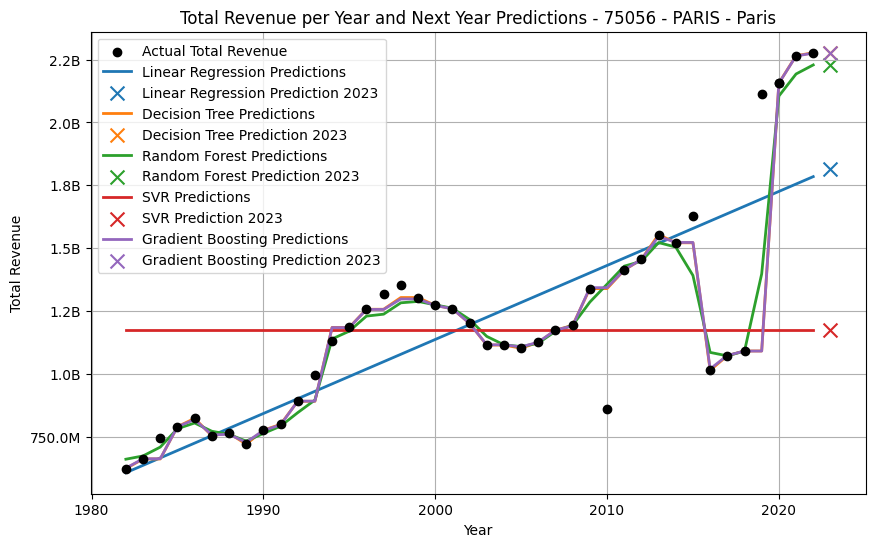

NMSE for Linear Regression on 13055 - MARSEILLE - Bouches-du-Rhône: 0.8518469666954873
13055 - MARSEILLE - Bouches-du-Rhône: Next Year Predicted Revenue by Linear Regression: 256.6M
NMSE for Decision Tree on 13055 - MARSEILLE - Bouches-du-Rhône: 0.6927498237616451
13055 - MARSEILLE - Bouches-du-Rhône: Next Year Predicted Revenue by Decision Tree: 479.8M
NMSE for Random Forest on 13055 - MARSEILLE - Bouches-du-Rhône: 0.5350130395986232
13055 - MARSEILLE - Bouches-du-Rhône: Next Year Predicted Revenue by Random Forest: 438.7M
NMSE for SVR on 13055 - MARSEILLE - Bouches-du-Rhône: 1.3960809237520937
13055 - MARSEILLE - Bouches-du-Rhône: Next Year Predicted Revenue by SVR: 178.3M
NMSE for Gradient Boosting on 13055 - MARSEILLE - Bouches-du-Rhône: 0.6908810188684825
13055 - MARSEILLE - Bouches-du-Rhône: Next Year Predicted Revenue by Gradient Boosting: 479.7M


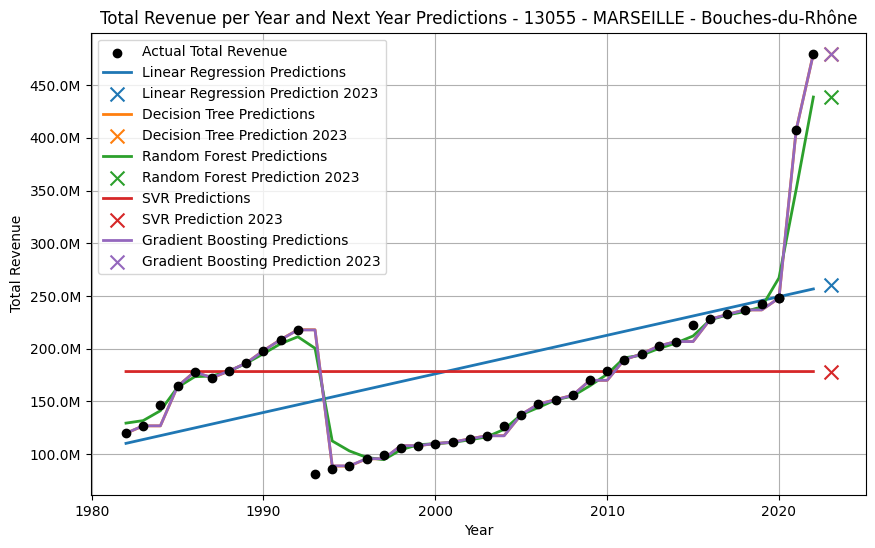

NMSE for Linear Regression on 69123 - LYON - Rhône: 0.6937053957645346
69123 - LYON - Rhône: Next Year Predicted Revenue by Linear Regression: 200.3M
NMSE for Decision Tree on 69123 - LYON - Rhône: 0.054959978464487955
69123 - LYON - Rhône: Next Year Predicted Revenue by Decision Tree: 310.7M
NMSE for Random Forest on 69123 - LYON - Rhône: 0.03757474972758061
69123 - LYON - Rhône: Next Year Predicted Revenue by Random Forest: 293.2M
NMSE for SVR on 69123 - LYON - Rhône: 1.0036338424272226
69123 - LYON - Rhône: Next Year Predicted Revenue by SVR: 128.3M
NMSE for Gradient Boosting on 69123 - LYON - Rhône: 0.05397732618688642
69123 - LYON - Rhône: Next Year Predicted Revenue by Gradient Boosting: 310.7M


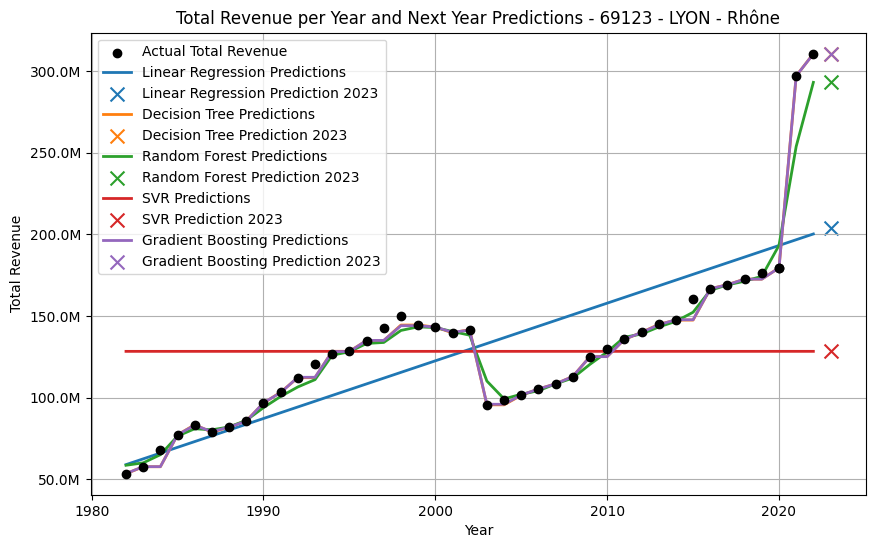

NMSE for Linear Regression on 31555 - TOULOUSE - Haute-Garonne: 1.2840840275661012
31555 - TOULOUSE - Haute-Garonne: Next Year Predicted Revenue by Linear Regression: 172.2M
NMSE for Decision Tree on 31555 - TOULOUSE - Haute-Garonne: 0.04373681403227663
31555 - TOULOUSE - Haute-Garonne: Next Year Predicted Revenue by Decision Tree: 281.0M
NMSE for Random Forest on 31555 - TOULOUSE - Haute-Garonne: 0.022743922072770074
31555 - TOULOUSE - Haute-Garonne: Next Year Predicted Revenue by Random Forest: 265.7M
NMSE for SVR on 31555 - TOULOUSE - Haute-Garonne: 1.4664098954038394
31555 - TOULOUSE - Haute-Garonne: Next Year Predicted Revenue by SVR: 126.7M
NMSE for Gradient Boosting on 31555 - TOULOUSE - Haute-Garonne: 0.04331371051336211
31555 - TOULOUSE - Haute-Garonne: Next Year Predicted Revenue by Gradient Boosting: 280.9M


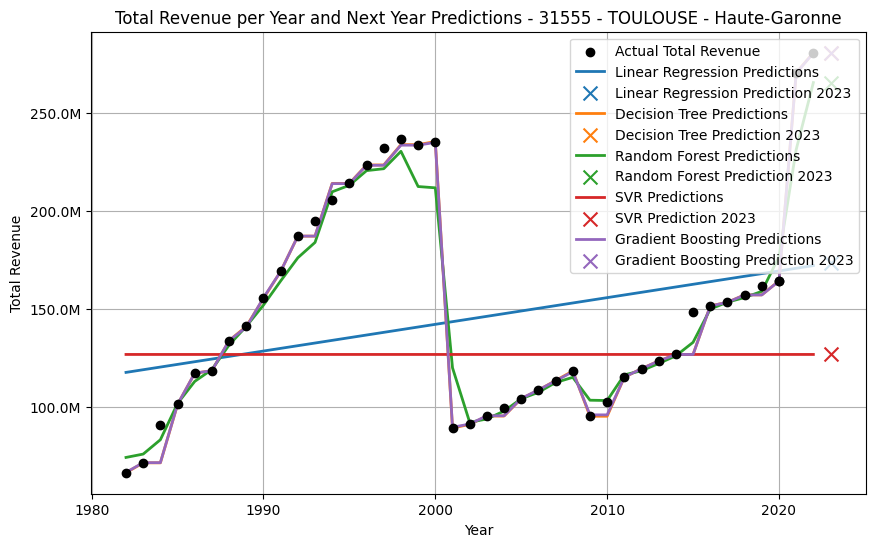

NMSE for Linear Regression on 06088 - NICE - Alpes-Maritimes: 1.3485788148848419
06088 - NICE - Alpes-Maritimes: Next Year Predicted Revenue by Linear Regression: 167.0M
NMSE for Decision Tree on 06088 - NICE - Alpes-Maritimes: 0.06000636462410409
06088 - NICE - Alpes-Maritimes: Next Year Predicted Revenue by Decision Tree: 241.6M
NMSE for Random Forest on 06088 - NICE - Alpes-Maritimes: 0.025998481377402193
06088 - NICE - Alpes-Maritimes: Next Year Predicted Revenue by Random Forest: 229.9M
NMSE for SVR on 06088 - NICE - Alpes-Maritimes: 1.0942233603913365
06088 - NICE - Alpes-Maritimes: Next Year Predicted Revenue by SVR: 137.9M
NMSE for Gradient Boosting on 06088 - NICE - Alpes-Maritimes: 0.059231412576365695
06088 - NICE - Alpes-Maritimes: Next Year Predicted Revenue by Gradient Boosting: 241.5M


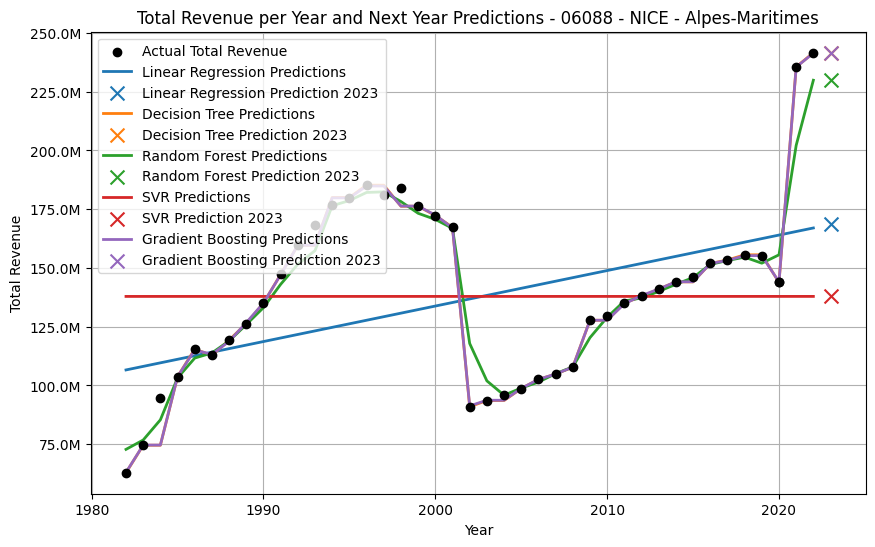

NMSE for Linear Regression on 33063 - BORDEAUX - Gironde: 0.6783203628814578
33063 - BORDEAUX - Gironde: Next Year Predicted Revenue by Linear Regression: 147.1M
NMSE for Decision Tree on 33063 - BORDEAUX - Gironde: 0.034422054429322224
33063 - BORDEAUX - Gironde: Next Year Predicted Revenue by Decision Tree: 220.5M
NMSE for Random Forest on 33063 - BORDEAUX - Gironde: 0.027667085674760214
33063 - BORDEAUX - Gironde: Next Year Predicted Revenue by Random Forest: 209.1M
NMSE for SVR on 33063 - BORDEAUX - Gironde: 1.0485532096748549
33063 - BORDEAUX - Gironde: Next Year Predicted Revenue by SVR: 88.4M
NMSE for Gradient Boosting on 33063 - BORDEAUX - Gironde: 0.03435203787359246
33063 - BORDEAUX - Gironde: Next Year Predicted Revenue by Gradient Boosting: 220.5M


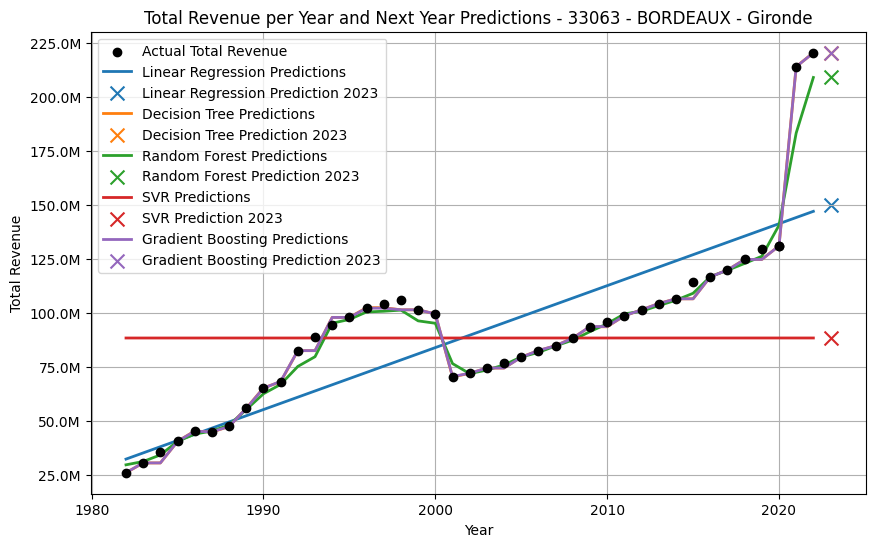

NMSE for Linear Regression on 34172 - MONTPELLIER - Hérault: 0.40349217139410676
34172 - MONTPELLIER - Hérault: Next Year Predicted Revenue by Linear Regression: 144.7M
NMSE for Decision Tree on 34172 - MONTPELLIER - Hérault: 0.02651512875678456
34172 - MONTPELLIER - Hérault: Next Year Predicted Revenue by Decision Tree: 220.1M
NMSE for Random Forest on 34172 - MONTPELLIER - Hérault: 0.017384252777246412
34172 - MONTPELLIER - Hérault: Next Year Predicted Revenue by Random Forest: 207.3M
NMSE for SVR on 34172 - MONTPELLIER - Hérault: 1.006184954368708
34172 - MONTPELLIER - Hérault: Next Year Predicted Revenue by SVR: 82.0M
NMSE for Gradient Boosting on 34172 - MONTPELLIER - Hérault: 0.02643086160728809
34172 - MONTPELLIER - Hérault: Next Year Predicted Revenue by Gradient Boosting: 220.1M


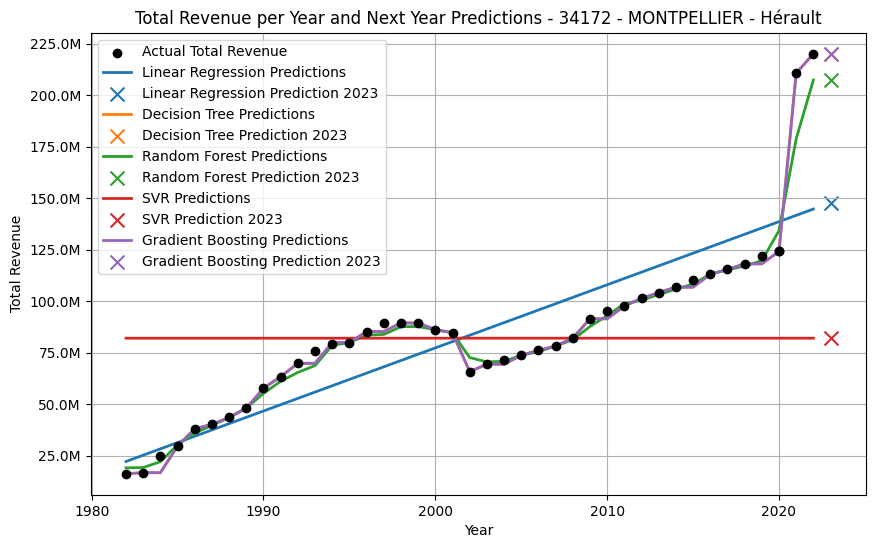

NMSE for Linear Regression on 44109 - NANTES - Loire-Atlantique: 1.5929792493175223
44109 - NANTES - Loire-Atlantique: Next Year Predicted Revenue by Linear Regression: 120.4M
NMSE for Decision Tree on 44109 - NANTES - Loire-Atlantique: 0.07345073839090104
44109 - NANTES - Loire-Atlantique: Next Year Predicted Revenue by Decision Tree: 201.2M
NMSE for Random Forest on 44109 - NANTES - Loire-Atlantique: 0.07410165687614323
44109 - NANTES - Loire-Atlantique: Next Year Predicted Revenue by Random Forest: 186.5M
NMSE for SVR on 44109 - NANTES - Loire-Atlantique: 1.4687028432453437
44109 - NANTES - Loire-Atlantique: Next Year Predicted Revenue by SVR: 84.3M
NMSE for Gradient Boosting on 44109 - NANTES - Loire-Atlantique: 0.07325067836148995
44109 - NANTES - Loire-Atlantique: Next Year Predicted Revenue by Gradient Boosting: 201.1M


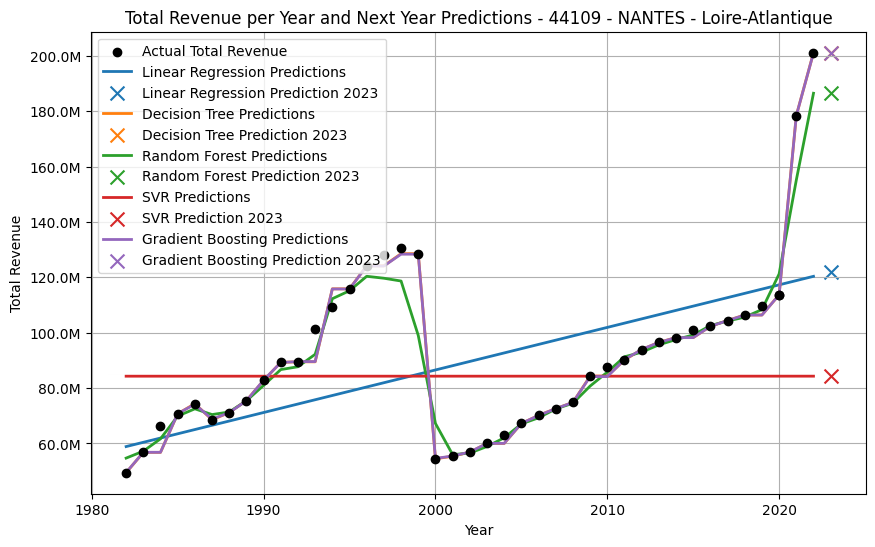

NMSE for Linear Regression on 67482 - STRASBOURG - Bas-Rhin: 1.315651302562663
67482 - STRASBOURG - Bas-Rhin: Next Year Predicted Revenue by Linear Regression: 105.9M
NMSE for Decision Tree on 67482 - STRASBOURG - Bas-Rhin: 0.050314218519758244
67482 - STRASBOURG - Bas-Rhin: Next Year Predicted Revenue by Decision Tree: 154.9M
NMSE for Random Forest on 67482 - STRASBOURG - Bas-Rhin: 0.05482034112833413
67482 - STRASBOURG - Bas-Rhin: Next Year Predicted Revenue by Random Forest: 147.1M
NMSE for SVR on 67482 - STRASBOURG - Bas-Rhin: 1.1316730525251997
67482 - STRASBOURG - Bas-Rhin: Next Year Predicted Revenue by SVR: 72.0M
NMSE for Gradient Boosting on 67482 - STRASBOURG - Bas-Rhin: 0.050573307264779606
67482 - STRASBOURG - Bas-Rhin: Next Year Predicted Revenue by Gradient Boosting: 154.9M


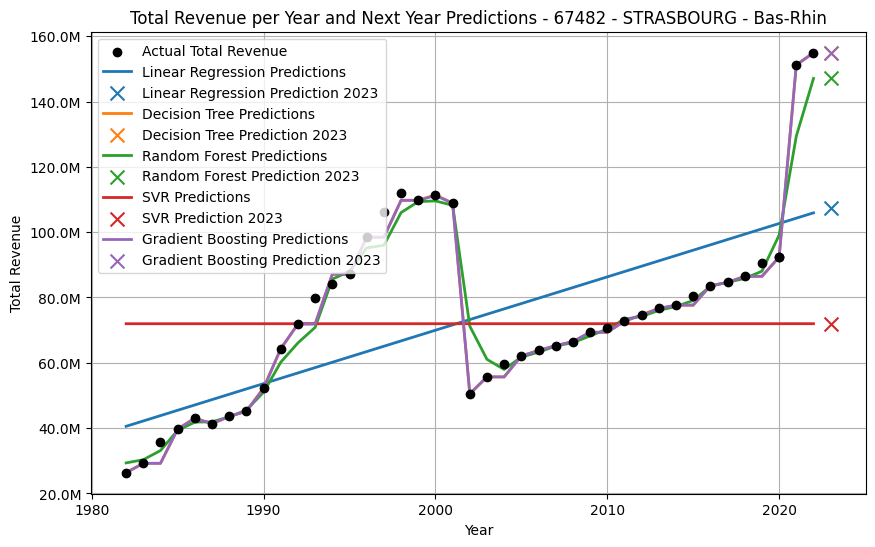

NMSE for Linear Regression on 59350 - LILLE - Nord: 0.9849034959490197
59350 - LILLE - Nord: Next Year Predicted Revenue by Linear Regression: 92.9M
NMSE for Decision Tree on 59350 - LILLE - Nord: 0.12856006622874686
59350 - LILLE - Nord: Next Year Predicted Revenue by Decision Tree: 142.5M
NMSE for Random Forest on 59350 - LILLE - Nord: 0.08934038608457633
59350 - LILLE - Nord: Next Year Predicted Revenue by Random Forest: 135.3M
NMSE for SVR on 59350 - LILLE - Nord: 1.2431703590678906
59350 - LILLE - Nord: Next Year Predicted Revenue by SVR: 59.1M
NMSE for Gradient Boosting on 59350 - LILLE - Nord: 0.12790251822045876
59350 - LILLE - Nord: Next Year Predicted Revenue by Gradient Boosting: 142.5M


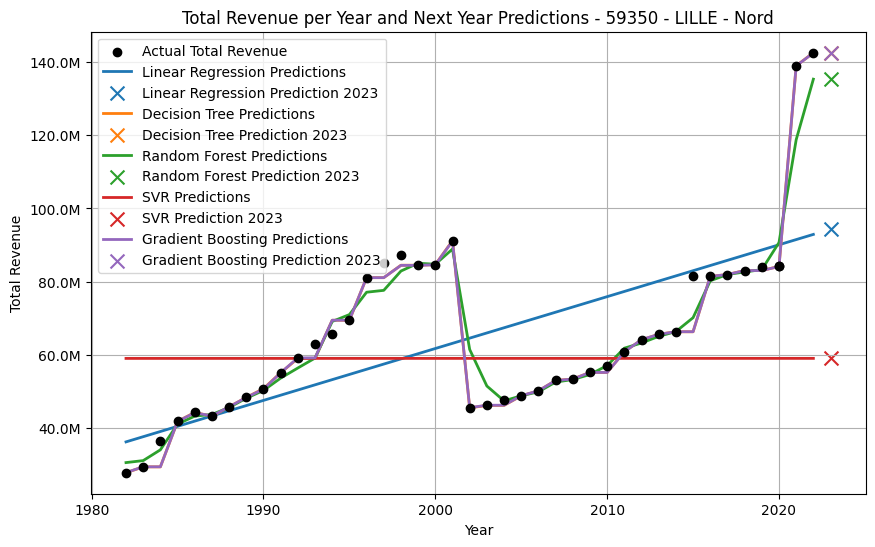

In [5]:
# Read the data
data_df = pd.read_parquet(input_parquet_file_path)
revenue_columns = data_df.columns[8:]

# Sum total tax revenue
data_df['Total Tax Revenue'] = data_df[revenue_columns].sum(axis=1)

# Group by code and year, then merge results back to the original dataframe
code_insee_identifier = 'Clean code INSEE'  # Adjust as necessary
grouped_result = data_df.groupby([code_insee_identifier, 'ANNEE'])['Total Tax Revenue'].sum().reset_index()
result = data_df.merge(grouped_result, on=[code_insee_identifier, 'ANNEE'], suffixes=('', '_Grouped'))

# Identify the latest year in the dataset
latest_year = result['ANNEE'].max()

# Filter the dataset to only include the latest year's data
latest_year_data = result[result['ANNEE'] == latest_year]

# Sort and obtain the top 10 communes based on 'Total Tax Revenue'
top_10_communes = latest_year_data.sort_values(by='Total Tax Revenue', ascending=False).head(10)

# Define the models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "SVR": SVR(kernel='linear'),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Different line styles and colors for the models
line_styles = ['-', '--', '-.', ':', '-']
colors = ['blue', 'green', 'red', 'purple', 'orange']


# Plotting results for each of the top 10 communes
for index, row in top_10_communes.iterrows():
    commune_code = row[code_insee_identifier]
    commune_label = row['LABEL']
    commune_data = result[result[code_insee_identifier] == commune_code]
    X = commune_data['ANNEE'].values.reshape(-1, 1)
    y = commune_data['Total Tax Revenue'].values
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color='black', label='Actual Total Revenue', zorder=3)
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X)
        
        # Predict the next year's revenue
        next_year = latest_year + 1
        next_year_pred = model.predict([[next_year]])
        
        nmse = mean_squared_error(y_test, model.predict(X_test)) / np.mean((y_test - np.mean(y_test)) ** 2)
        print(f'NMSE for {model_name} on {commune_label}: {nmse}')
        print(f'{commune_label}: Next Year Predicted Revenue by {model_name}: {human_readable_format(y_pred[0])}')
        
        plt.plot(X, y_pred, label=f'{model_name} Predictions', linewidth=2)
        plt.scatter([next_year], next_year_pred, label=f'{model_name} Prediction {next_year}', marker='x', s=100)
        
    plt.title(f'Total Revenue per Year and Next Year Predictions - {commune_label}')
    plt.xlabel('Year')
    plt.ylabel('Total Revenue')
    plt.legend(loc='upper left')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(human_readable_format))  # Apply the formatter
    plt.legend()
    plt.grid(True)
    plt.show()
